In [ ]:
# @title Import Requirements
import os
import io
import gc
import random

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from tqdm.notebook import tqdm
from IPython.display import clear_output
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from transformers import (
    BertConfig,
    BertTokenizer,
    TFBertForSequenceClassification
)
from transformers.activations_tf import ACT2FN

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
 try:
  tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
  tf.config.experimental.set_memory_growth(gpus[0], True)
  print(gpus[0])
 except RuntimeError as e:
  print(e)

# try:
#   tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#   print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
# except ValueError:
#   raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [ ]:
fdir = './NLP/Data/SentEval/data/probing/'

BATCH_SIZE = 256
MAX_LENGTH = 48
no_examples = 9996

TASK_NAME = 'past_present.txt'

CLASSIFIER_MODEL_FPATH = './NLP/Models/SentEvalAnalysis/BERT_AVG_Classifiers/'

pretrained_loc = "bert-base-uncased"
print("Running with:", pretrained_loc)

Running with: bert-base-uncased


In [ ]:
# @title Required Functions & Classes
def load_probing_data(fpath, additive=''):
    task_data = {'train': {'X': [], 'y': []},
                 'dev': {'X': [], 'y': []},
                 'test': {'X': [], 'y': []}}


    tok2split = {'tr': 'train', 'va': 'dev', 'te': 'test'}
    with io.open(fpath, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.rstrip().split('\t')
            task_data[tok2split[line[0]]]['X'].append(additive + line[-1])
            task_data[tok2split[line[0]]]['y'].append(line[1])

        if fpath == '/home/username/SentEval/data/probing/tree_depth.txt':
            labels = ['5', '6', '7', '8', '9', '10', '11']
            tok2label = dict(zip(labels, [0, 1. / 6, 2. / 6, 3. / 6, 4. / 6, 5. / 6, 1]))
        else:
            labels = sorted(np.unique(task_data['train']['y']))
            tok2label = dict(zip(labels, range(len(labels))))
        nclasses = len(tok2label)

        for split in task_data:
            for i, y in enumerate(task_data[split]['y']):
                task_data[split]['y'][i] = tok2label[y]

    return task_data, tok2label, nclasses

class BertReprProbing(tf.keras.Model):
    def __init__(self, bert_model, **kwargs):
        super(BertReprProbing, self).__init__(name="BertReprProbing")
        self.bert = bert_model

    def call(self, inputs, **kwargs):
        middle_hidden_states = self.bert(inputs, **kwargs)[2]
        output = []
        for i in range(1, 13):
            output.append(middle_hidden_states[i])
        return tf.stack(output)

@tf.function
def tf_average(hidden_states, att_mask, w):
  max_length = tf.cast(tf.shape(att_mask)[1], tf.float32)
  att_mask = tf.cast(att_mask[:, 1:], tf.float32)
  avg = tf.reshape(tf.matmul(tf.transpose(hidden_states[:, 1:] * tf.expand_dims(att_mask, axis=-1), perm=[0, 2, 1]), w), (-1, 768))
  avg = avg * tf.cast((max_length - 1.0) / tf.reduce_sum(att_mask, axis=-1, keepdims=True), tf.float32)
  return avg

In [ ]:
# @title Load BERT Model
config = BertConfig.from_pretrained(pretrained_loc, output_hidden_states=True)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
loaded_model = TFBertForSequenceClassification.from_pretrained(pretrained_loc,
                                                               config=config)

probing_model = BertReprProbing(loaded_model.bert)
clear_output()
print("Done!")

Done!


In [ ]:
# @title Probe Feature Extraction
probe_path = fdir + TASK_NAME
task_data, tok2label, nclasses = load_probing_data(probe_path)
print("Probe Loaded:", TASK_NAME)

steps = int(np.ceil(no_examples / BATCH_SIZE))

# Shuffle two lists with same order
# Using zip() + * operator + shuffle()
# temp = list(zip(task_data['test']['X'], task_data['test']['y']))
# random.shuffle(temp)
# task_data['test']['X'], task_data['test']['y'] = zip(*temp)
task_data['test']['y'] = np.array(task_data['test']['y'][:no_examples])

### Free some RAM!!!
# del temp
del task_data['train']
del task_data['dev']
gc.collect()

hidden_representations = np.zeros((12, no_examples, MAX_LENGTH, 768), dtype=np.float32)
token_ids = np.zeros((no_examples, MAX_LENGTH), dtype=np.int32)
att_masks = np.zeros((no_examples, MAX_LENGTH), dtype=np.int32)

print("Starting probe feature extraction:", TASK_NAME)

for i in tqdm(range(steps)):
    tokens_batched = tokenizer.batch_encode_plus(task_data['test']['X'][i * BATCH_SIZE:min((i + 1) * BATCH_SIZE, no_examples)],
                                                 max_length=MAX_LENGTH,
                                                 return_tensors='tf',
                                                 truncation=True,
                                                 pad_to_max_length=True)

    hidden_representations[:,
    i * BATCH_SIZE:(i + 1) * BATCH_SIZE, :, :] = probing_model(tokens_batched, training=False).numpy()
                                                             
    att_masks[i * BATCH_SIZE:(i + 1) * BATCH_SIZE, :] = tokens_batched['attention_mask']
    token_ids[i * BATCH_SIZE:(i + 1) * BATCH_SIZE, :] = tokens_batched['input_ids']

In [ ]:
# @title Importance Computation

saliances = np.zeros((12, nclasses, no_examples, MAX_LENGTH))

weights = tf.Variable(np.ones((MAX_LENGTH-1, 1)) / (MAX_LENGTH-1), dtype=tf.float32, trainable=True)

BATCH_SIZE = 128
steps = int(np.ceil(no_examples / BATCH_SIZE))

for i in range(12):
    print("Load classifier", i)
    classifier = tf.keras.models.load_model(CLASSIFIER_MODEL_FPATH + TASK_NAME[:-4] + '/' + str(i))
    acc = 0.0
    for j in tqdm(range(steps)):
        with tf.GradientTape() as tape:
            avgs = tf_average(hidden_representations[i, j * BATCH_SIZE:(j + 1) * BATCH_SIZE, :, :],
                              att_masks[j * BATCH_SIZE:(j + 1) * BATCH_SIZE, :], weights)
            probs = classifier(avgs)
            sing_probs = probs[:, 0]
        grads = tape.gradient(sing_probs, avgs)
        salience_scores = tf.expand_dims(grads, axis=1) * hidden_representations[i, j * BATCH_SIZE:(j + 1) * BATCH_SIZE, :, :] * tf.cast(tf.expand_dims(att_masks[j * BATCH_SIZE:(j + 1) * BATCH_SIZE, :], axis=-1), dtype=tf.float32)

        saliances[i][0][j * BATCH_SIZE:(j + 1) * BATCH_SIZE, 1:] = tf.reduce_sum(salience_scores[:, 1:, :], axis=-1).numpy()
        saliances[i][1][j * BATCH_SIZE:(j + 1) * BATCH_SIZE, 1:] = - saliances[i][0][j * BATCH_SIZE:(j + 1) * BATCH_SIZE, 1:]
        
        acc += np.mean(tf.argmax(probs, axis=-1).numpy() == task_data['test']['y'][j * BATCH_SIZE:(j + 1) * BATCH_SIZE])
        
    print(acc / steps)

Load classifier 0



0.8671215717299579
Load classifier 1



0.8779008438818566
Load classifier 2



0.8728902953586497
Load classifier 3



0.8876911919831224
Load classifier 4



0.890625
Load classifier 5



0.8871637658227848
Load classifier 6



0.8903283227848101
Load classifier 7



0.8837354957805907
Load classifier 8



0.8908557489451477
Load classifier 9



0.8899657172995781
Load classifier 10



0.8830762130801687
Load classifier 11



0.8849222046413503


In [ ]:
# @title Post Processing
unique_tokens, token_inverse, token_counts = np.unique(token_ids, return_counts=True, return_inverse=True)

gold_importance = np.empty((12, no_examples, MAX_LENGTH))
for i in range(no_examples):
  gold_importance[:, i] = saliances[:, task_data['test']['y'][i], i]

### Token-based Analysis

In [ ]:
import matplotlib as mpl
 
mpl.rcParams['axes.linewidth'] = 1.7 #set the value globally

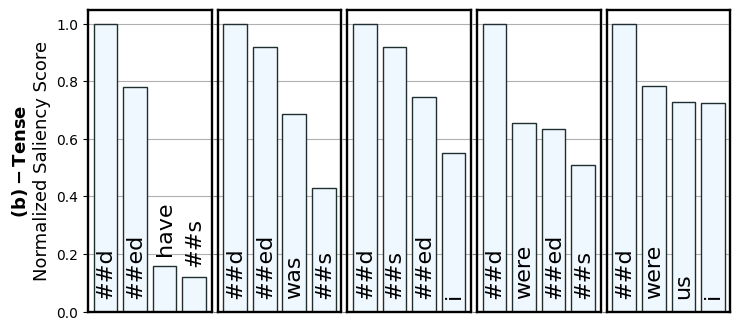

In [ ]:
# @title Top words importance - ABSOLUTE
TOP_TOKENS_TO_SHOW = 4

import matplotlib

fig = plt.figure(figsize = (20,4), dpi=100)
fig.subplots_adjust(wspace=0.05)
top_tokens = np.argwhere(token_counts > 128)[2:].flatten()
cmap = matplotlib.cm.get_cmap('summer')

top_imps = []
for l_idx, layer_num in enumerate([0, 3, 6, 9, 11]):
  top_tokens_importances = []
  for i in top_tokens:
    mean_imp = np.mean(gold_importance[layer_num][token_ids == unique_tokens[i]])
    top_tokens_importances.append(mean_imp)
  
  labels = []
  imps = []
  top_tokens_importances = np.array(top_tokens_importances)
  top_imps.append(top_tokens_importances)
  for i in reversed(np.argsort(top_tokens_importances)[-TOP_TOKENS_TO_SHOW:]):
    labels.append(tokenizer.decode([unique_tokens[top_tokens[i]]]))
    imps.append(top_tokens_importances[i])

  ax = fig.add_subplot(1, 12, l_idx+1, fc='#FFFFFF')
  ax.grid('on', axis='y')
  ax.set_axisbelow(True)
  ax.bar(np.arange(TOP_TOKENS_TO_SHOW), imps / np.max(imps), align='center', color='aliceblue', edgecolor='#1f2e2e', linewidth=1)
  for i, (p, pr) in enumerate(zip(labels, imps / np.max(imps))):
    y_base = (pr + 0.05 if pr < 0.22 else 0.06)
    color = 'k'
    ax.text(s=p, x=i+0.03-TOP_TOKENS_TO_SHOW/11, y=y_base, color=color, size=16, rotation=90, weight='normal')
    ax.set_xticks([])
  if l_idx != 0:
    ax.tick_params(axis='y', colors='gray')
    ax.set_yticklabels([])
  else:
    ax.set_ylabel(r"$\bf{(b) - Tense}$"+"\nNormalized Saliency Score", size=13)
  # ax.set_title('Layer ' + str(layer_num + 1), size=15)
  # ax.set(frame_on=False)

# fig.tight_layout()
plt.show()

In [ ]:
def single_token_analysis(token_id):
  positions = np.argwhere(token_ids == token_id)
  layer_no = []
  importance = []
  representations = []
  labels = []

  for pos in positions:
    for i in range(12):
      importance.append(gold_importance[i][pos[0]][pos[1]])
      layer_no.append(i)
      representations.append(hidden_representations[i][pos[0]][pos[1]])
    labels.append(task_data['test']['y'][pos[0]])
  
  return (positions, np.array(layer_no), np.array(importance), np.array(representations), np.array(labels))

In [ ]:
# @title Multi-token TSNE Plot
def multi_tokens_info(selected_tokens):
  id = []
  position = []
  layer_no = []
  importance = []
  representations = []
  labels = []

  for i, token in enumerate(selected_tokens):
    info = single_token_analysis(tokenizer.get_vocab()[token])

    for j in range(len(info[0])):
      id.append(i)
      position.append(info[0][j])
      labels.append(info[4][j])

    for j in range(len(info[1])):
      layer_no.append(info[1][j])
      importance.append(info[2][j])
      representations.append(info[3][j])
    
  return (np.array(id), 
          np.array(position), 
          np.array(layer_no), 
          np.array(importance),
          np.array(representations),
          np.array(labels))

In [ ]:
SELECTED_TOKENS = ['##s', 'does', 'children', 'men', 'works']
combined_info = multi_tokens_info(SELECTED_TOKENS)

In [ ]:
from tsnecuda import TSNE

tsnes = []
for j, layer_num in enumerate(range(12)):
  X_embedded = TSNE(n_components=2, perplexity=40).fit_transform(combined_info[4][combined_info[2]==layer_num])
  tsnes.append(X_embedded)

tsnes = np.array(tsnes)

In [ ]:
np.save('NLP/Projects/SentEval/tsne_cache', tsnes)

In [ ]:
tsnes = np.load('NLP/Projects/SentEval/tsne_cache.npy')

In [ ]:
with open(r"NLP/Projects/SentEval/combined_info.pkl", "rb") as input_file:
   combined_info = pickle.load(input_file)

In [ ]:
import pickle

with open('NLP/Projects/SentEval/combined_info.pkl', 'wb') as output:
  pickle.dump(combined_info, output, pickle.HIGHEST_PROTOCOL)

In [ ]:
SELECTED_TOKENS = ['##s', 'does', 'children', 'men', 'works']

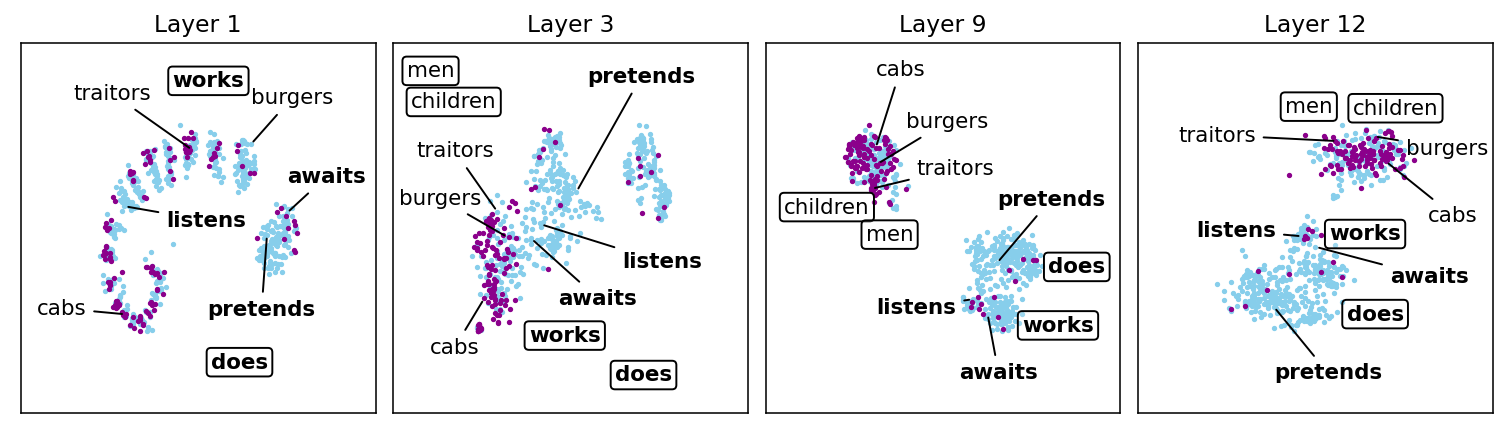

In [ ]:
fig = plt.figure(figsize = (17, 3.5), dpi=140)
from tsnecuda import TSNE
from adjustText import adjust_text

fig.subplots_adjust(wspace=0.05)

color_map = [(1, 140./255, 0./255, 0.6), (54./255, 242./255, 240./255, 0.6), 'y', 'r', 'm', 'k', 'c']
markers = ['o', 'o']

for j, layer_num in enumerate([0, 2, 8, 11]):
  X_embedded = tsnes[layer_num]
  ax = fig.add_subplot(1, 5, j+1)
  ax.set_title("Layer " + str(layer_num+1))
  ax.set_xticks([])
  ax.set_yticks([])
  ax.scatter(X_embedded[(combined_info[5] == 1) * (combined_info[0] == 0), 0], X_embedded[(combined_info[5] == 1) * (combined_info[0] == 0), 1], c='skyblue', s=3, marker=markers[0])
  ax.scatter(X_embedded[(combined_info[5] == 0) * (combined_info[0] == 0), 0], X_embedded[(combined_info[5] == 0) * (combined_info[0] == 0), 1], c='darkmagenta', s=3, marker=markers[1])
  ax.margins(y=0.4, x=0.4)

  texts_annotate = []
  l = 0
  for i, pos in enumerate(combined_info[1][combined_info[0] == 0]):
    ###      burgers, cabs, traitors, awaits, listens, pretends
    if i in [145,     224,  357,      420,    470,     556]:
      # plt.text(X_embedded[combined_info[0] == 0, 0][i], 
      #         X_embedded[combined_info[0] == 0, 1][i], 
      #         tokenizer.decode([token_ids[pos[0]][pos[1] - 2], token_ids[pos[0]][pos[1] - 1], 2015]).split(' ')[-1])
      plt.annotate(tokenizer.decode([token_ids[pos[0]][pos[1] - 2], token_ids[pos[0]][pos[1] - 1], 2015]).split(' ')[-1],
                   xy=(X_embedded[combined_info[0] == 0, 0][i], X_embedded[combined_info[0] == 0, 1][i]),
                   xytext=(X_embedded[combined_info[0] == 0, 0][i] + MANUAL_ADJUST[j][l][0], X_embedded[combined_info[0] == 0, 1][i] + MANUAL_ADJUST[j][l][1]) ,
                   fontsize=11, arrowprops=dict(arrowstyle="-"), weight='normal' if i < 400 else 'bold')
      l += 1
      # texts_x.append(X_embedded[combined_info[0] == 0, 0][i])
      # texts_y.append(X_embedded[combined_info[0] == 0, 1][i])
      # texts_annotate.append(tokenizer.decode([token_ids[pos[0]][pos[1] - 2], token_ids[pos[0]][pos[1] - 1], 2015]).split(' ')[-1])
  
  OFFSET = 0
  for k in range(1, 5):
    plt.annotate(SELECTED_TOKENS[k],
                    xy=(X_embedded[combined_info[0] == k, 0][OFFSET], X_embedded[combined_info[0] == k, 1][OFFSET]),
                    xytext=(X_embedded[combined_info[0] == k, 0][OFFSET] + MANUAL_ADJUST[j][l][0], X_embedded[combined_info[0] == k, 1][OFFSET] + MANUAL_ADJUST[j][l][1]) ,
                    fontsize=11, bbox=dict(boxstyle="round", fc=(1, 1, 1, 0.2), 	pad=0.2), weight='normal' if k == 2 or k == 3 else 'bold')
    l += 1

  # adjust_text(texts_annotate, add_objects=repels, force_objects=(0,0), arrowprops=dict(arrowstyle='-', color='black'), force_text=(0, 0), force_points=(0,0))
  # adjust_text(texts_annotate ,arrowprops=dict(arrowstyle='-', color='black'))
plt.show()
  # repel_labels(ax, texts_x, texts_y, texts_annotate)

In [ ]:
###      burgers, cabs, traitors, awaits, listens, pretends, 'does', 'children', 'men', 'works'
####    [145,     224,  357,      420,    470,     556]:

MANUAL_ADJUST = [[[0,4], [-15,0], [-20,5], [0,3], [7,-2], [-10,-8], [0,-3], [20,0], [20,0], [0,5]], 
                 [[-20,3], [-10,-5], [-15,5], [5,-6], [15,-4], [2,10], [0,-8], [2,-0.5], [2,1], [0,-5]],
                 [[5,5], [0,10], [8,2], [-5,-9], [-17,-2], [0,8], [9,0], [-12,2], [1,0], [9,-2]],
                 [[3,-3], [4,-10], [-15,0], [7,-6], [-10,0], [0,-12], [5,-6], [3,0], [-1,0], [3,-3]]]

In [ ]:
MANUAL_ADJUST = [[[0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0]], 
                 [[0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0]],
                 [[0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0]],
                 [[0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0]]]

In [ ]:
ax.bbox.get_points()

array([[1010.60096154,   43.75      ],
       [1263.96634615,  308.        ]])

In [ ]:
for i, pos in enumerate(combined_info[1][combined_info[0] == 0]):
  print(i, tokenizer.decode([token_ids[pos[0]][pos[1] - 2], token_ids[pos[0]][pos[1] - 1], 2015]).split(' ')[-1])

0 contractions
1 sparkles
2 sips
3 straightens
4 cleans
5 tingles
6 jocks
7 wipes
8 bounces
9 dissolves
10 scowls
11 suitcases
12 whistles
13 dips
14 wipes
15 retorts
16 ##ysterics
17 interrupts
18 falters
19 assures
20 loosens
21 sips
22 interrupts
23 assures
24 suitcases
25 pleads
26 eases
27 loosens
28 tightens
29 burritos
30 rips
31 tightens
32 claps
33 fiddles
34 curios
35 errands
36 errands
37 stirs
38 resumes
39 stomps
40 struts
41 hums
42 innocents
43 ripples
44 assures
45 hesitates
46 huffs
47 falters
48 recovers
49 scowls
50 railings
51 stirs
52 televisions
53 sorcerers
54 mutters
55 meds
56 scraps
57 tilts
58 burkes
59 tightens
60 assurances
61 breathes
62 interns
63 goodbyes
64 shoves
65 tightens
66 winces
67 flickers
68 flashlights
69 alchemists
70 falters
71 umbrellas
72 howls
73 notables
74 weaves
75 gulps
76 speckles
77 mags
78 fleas
79 ##roaches
80 gowns
81 snarls
82 awaits
83 hunches
84 treks
85 shoves
86 heals
87 heals
88 ##cribes
89 krauss
90 bounces
91 squeezes
92 